Юденков Павел Александрович

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.alexnet import alexnet, AlexNet_Weights
from torchvision.datasets import MNIST
import torchvision
import os
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
mobModel = alexnet(weights=AlexNet_Weights) # ссоздаем alexnet с предобученными весами

/home/kitkeyubuntumain/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
pretrainedLayers = nn.Sequential(*list(mobModel.children()))[:-2] # берем только сверточные слои
for param in pretrainedLayers.parameters():
    param.requires_grad = False # замораживаем параметры в каждом слое

In [ ]:
pretrainedLayers

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [ ]:
class contrastiveModel(nn.Module): # создаем свою модель
    def __init__(self):
        super().__init__()
        self.sequential_pretrained = pretrainedLayers # замороженные сверточные слои alexnet
        self.mlp_seq = nn.Sequential( # собственная mlp
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.PReLU(),
            nn.Linear(256, 256),
            nn.PReLU(),
            nn.Linear(256,100)
        )
    def forward(self, image1, image2):
        return self.mlp_seq(self.sequential_pretrained(image1)), self.mlp_seq(self.sequential_pretrained(image2)) # прямой проход

In [ ]:
# Заимствованно из https://colab.research.google.com/drive/1FsixLon5Zz3_rFA0xIHzc8Tvnnw8FLr8#scrollTo=nBjCIlhWk2MT
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2) # вычисляем Евклидово расстояние

        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) # вычисляем loss


        return loss_contrastive

In [ ]:
class PairTrainDataset(torch.utils.data.Dataset): # тренировочный датасет
    def __init__(self):
        self.dir = os.path.curdir
        weights = AlexNet_Weights.DEFAULT  # берем веса для дальнейшей трансформации
        preprocess = weights.transforms() # трансформации чтобы картинки подавались на вход конволюционных слоев alexnet хорошо
        self.transform = transforms.Compose( # композиция трансформаций
            [transforms.Grayscale(3), # увеличиваем до трех количество канало для alexnet
             preprocess,
            ])
        self.data_basic = MNIST(root=self.dir, download=True, train=True, transform=self.transform) # используем тренировочный MNIST
        data = []
        for class_number in range(10): # проходим по каждому классу
            indexes = (self.data_basic.targets == class_number).nonzero(as_tuple=True)[0] # берем индексы элементов targets, где элементы принадлежат этому классу
            for j in range(300): # 300 тренировочных одинаковых элементов принадлежащих этому классу (similar)
                random_pair_similar_idx = np.random.choice(indexes, size=2) # выбираем пару индексов
                label = int(self.data_basic[random_pair_similar_idx[0]][1] == self.data_basic[random_pair_similar_idx[1]][1])
                data.append((self.data_basic[random_pair_similar_idx[0]][0], self.data_basic[random_pair_similar_idx[1]][0], label)) # добавляем в датасет тройку из изображения 1, изображения 2 и их similarity
            for k in range(300): # 300 тренирочных элементов, где один элемент - элемент данного класса, другой - может быть любым
                random_pair_dsimilar_idx = [int(np.random.choice(indexes, size=1)[0]),int(np.random.choice(range(len(self.data_basic.targets)), size=1)[0])] # выбираем пару индексов
                label = int(self.data_basic[random_pair_dsimilar_idx[0]][1] == self.data_basic[random_pair_dsimilar_idx[1]][1]) # проверяем label
                data.append((self.data_basic[random_pair_dsimilar_idx[0]][0], self.data_basic[random_pair_dsimilar_idx[1]][0], label))
        self.dataset = data
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        return sample


In [ ]:
class PairTestDataset(torch.utils.data.Dataset): # Класс датасета для теста, все аналогично тренировочному датасету, но берем по 500 пар similar и 500 пар desimilar
    def __init__(self):
        self.dir = os.path.curdir
        weights = AlexNet_Weights.DEFAULT
        preprocess = weights.transforms()
        self.transform = transforms.Compose(
            [transforms.Grayscale(3),
             preprocess,
            ])
        self.data_basic = MNIST(root=self.dir, download=True, train=False, transform=self.transform)
        data = []
        count_positive = 500
        count_negative = 500
        self.data_positive = []
        self.data_negative = []
        while count_positive > 0 or count_negative > 0:
            class_number_pos = np.random.randint(0, 10, size=1)[0]
            class_number_neg = np.random.randint(0, 10, size=1)[0]

            indexes_over = torch.Tensor()

            if count_positive:
                indexes_pos = (self.data_basic.targets == class_number_pos).nonzero(as_tuple=True)[0]
                random_pair_similar_idx = np.random.choice(indexes_pos, size=2)
                label = int(self.data_basic[random_pair_similar_idx[0]][1] == self.data_basic[random_pair_similar_idx[1]][1])
                self.data_positive.append((self.data_basic[random_pair_similar_idx[0]][0], self.data_basic[random_pair_similar_idx[1]][0], label))
                count_positive -= 1
            if count_negative:
                indexes_neg = (self.data_basic.targets == class_number_pos).nonzero(as_tuple=True)[0]
                for j in range(10):
                    if j != class_number_neg:
                        indexes_over = torch.cat((indexes_over,(self.data_basic.targets == j).nonzero(as_tuple=True)[0]), dim=-1)
                indexes_over = indexes_over.int()
                random_pair_dsimilar_idx = [int(np.random.choice(indexes_neg, size=1)[0]),int(np.random.choice(indexes_over, size=1)[0])]
                label = int(self.data_basic[random_pair_dsimilar_idx[0]][1] == self.data_basic[random_pair_dsimilar_idx[1]][1])
                self.data_negative.append((self.data_basic[random_pair_dsimilar_idx[0]][0], self.data_basic[random_pair_dsimilar_idx[1]][0], label))
                count_negative -= 1
        self.dataset = self.data_positive+self.data_negative
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        return sample

In [ ]:
pair_train_dataset = PairTrainDataset() # создаем тренировчный датасет

In [ ]:
s = DataLoader(dataset=pair_train_dataset, batch_size=20,shuffle=True) # загружаем тренировочный датасет для обучения батчами
model = contrastiveModel().to(device) # создаем модель
optimizer = torch.optim.Adagrad(model.parameters(), lr=5e-6, eps=1e-08, weight_decay=0.0002) # настраиваем optimizer

In [ ]:
epochs = 15
contr_loss = ContrastiveLoss()

total_loss = []
for batch in tqdm(s): # идем по тренировочным батчам
    for epoch in range(epochs):
        img0, img1, label = batch # берем из батча картинки и их схожесть

        img_vec1, img_vec2 = model.forward(img0.to(device), img1.to(device)) # прогоняем картинки через модель, получаем их представления
        optimizer.zero_grad() # обнуляем предыдущий градиент
        loss = contr_loss.forward(img_vec1, img_vec2, label.to(device)) # вычисляем лосс
        total_loss.append(float(loss))
        loss.backward() # обратный проход
        optimizer.step() # корректируем веса

100%|█████████████████████████████████████████| 300/300 [00:27<00:00, 11.05it/s]


In [ ]:
test_dataset = PairTestDataset() # тестовый датасет
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False) # загружаем батчами по 1

In [ ]:
count = 0
acc = 0 # сюда будут складываться правильные ответы
tp = 0 # true-positive
tn = 0 # true-negative
fp = 0 # false-positive
fn = 0 # false-negative
for batch in tqdm(test_loader):
    img1, img2, labels = batch # берем картинки и схожесть из батча
    img_vec1, img_vec2 = model.forward(img1.to(device), img2.to(device)) # и тд прям как в тренировочном
    distance = F.pairwise_distance(img_vec1, img_vec2)# Вычисляем Евклидово расстояние
    is_similar = labels.to(device)
    result= distance.data[0]<0.47 # Порог схожести - 0.45
    if (result == is_similar == 1): # большой if для подготовки к вычислению метрик
        tp += 1
    elif (result == is_similar == 0):
        tn += 1
    elif (result != is_similar) and (result == 0):
        fn += 1
    elif (result != is_similar) and (result == 1):
        fp += 1
    acc += result == is_similar

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1220.99it/s]


In [ ]:
print(acc / 1000, " precision: ", tp / (tp + fp), " recall: ", tp / (tp + fn)) # метрики


tensor([0.6830], device='cuda:0')  precision:  0.6774691358024691  recall:  0.8025594149908593


In [ ]:
print(model) # вывод структуры модели

contrastiveModel(
  (sequential_pretrained): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (mlp_seq): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_di

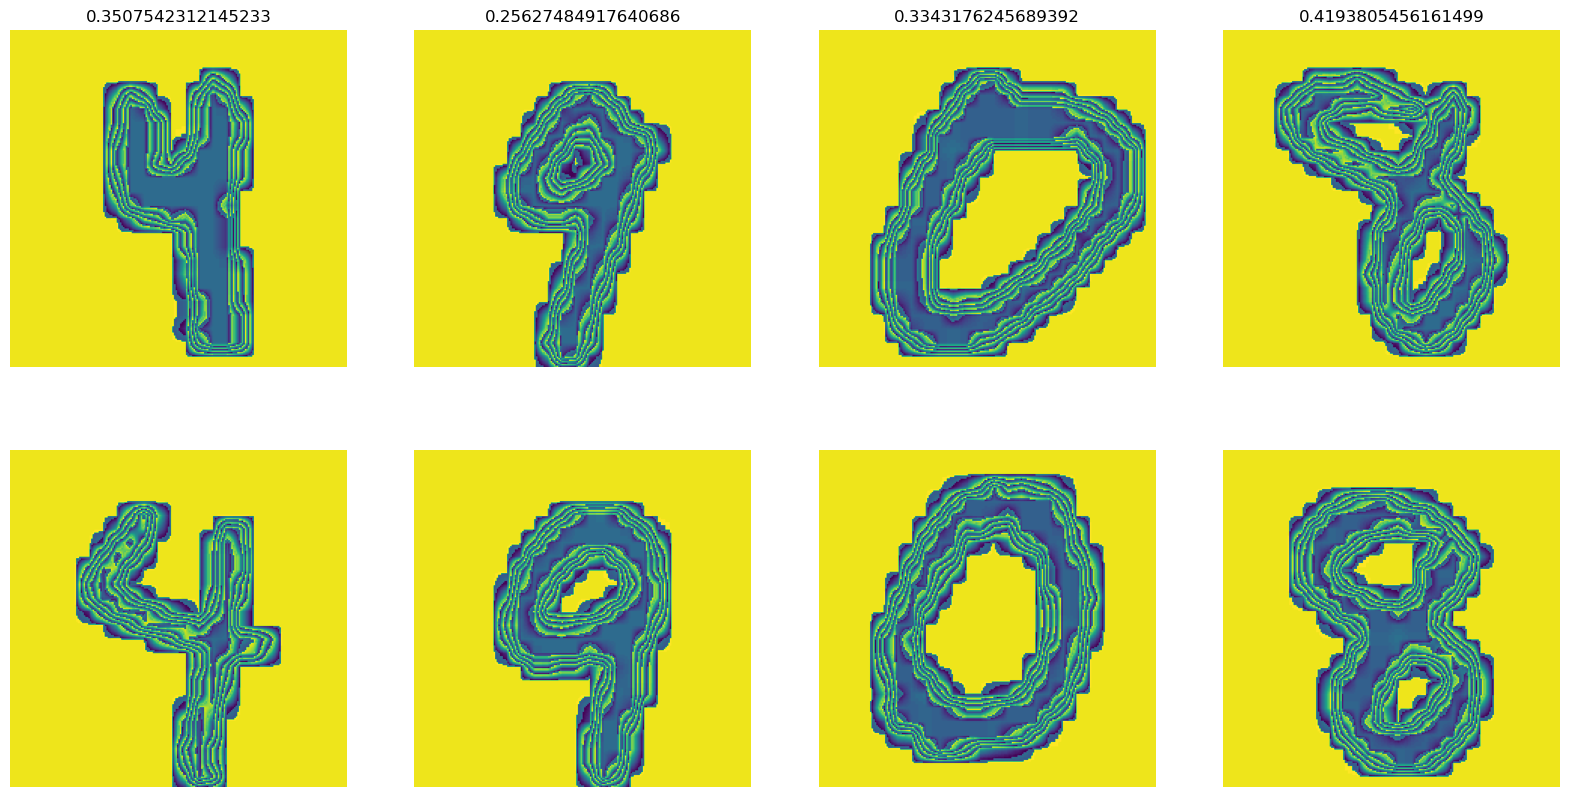

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10)) # полотно с количеством рядов, столбцов и тд

for i in range(4):
    indexes = np.random.choice(range(0, 500), size=1) # индексы similar элементов в тестовом датасете
    img_vec1, img_vec2 = model.forward(test_dataset[indexes[0]][0].unsqueeze(0).to(device), test_dataset[indexes[0]][1].unsqueeze(0).to(device))

    distance = F.pairwise_distance(img_vec1, img_vec2) # дистанция между представлениями
    img1 = torchvision.transforms.functional.to_tensor(torchvision.transforms.functional.to_pil_image(test_dataset[indexes[0]][0]).convert('L'))
    img2 = torchvision.transforms.functional.to_tensor(torchvision.transforms.functional.to_pil_image(test_dataset[indexes[0]][1]).convert('L'))

    tensor1 = torch.from_numpy(np.array(img1))
    tensor2 = torch.from_numpy(np.array(img2))
    axs[0, i].imshow(tensor1.permute(1, 2, 0)) # выводы на
    axs[1, i].imshow(tensor2.permute(1, 2, 0))

    axs[0, i].axis('off')
    axs[0, i].set_title(float(distance.data[0]))
    axs[1, i].axis('off')


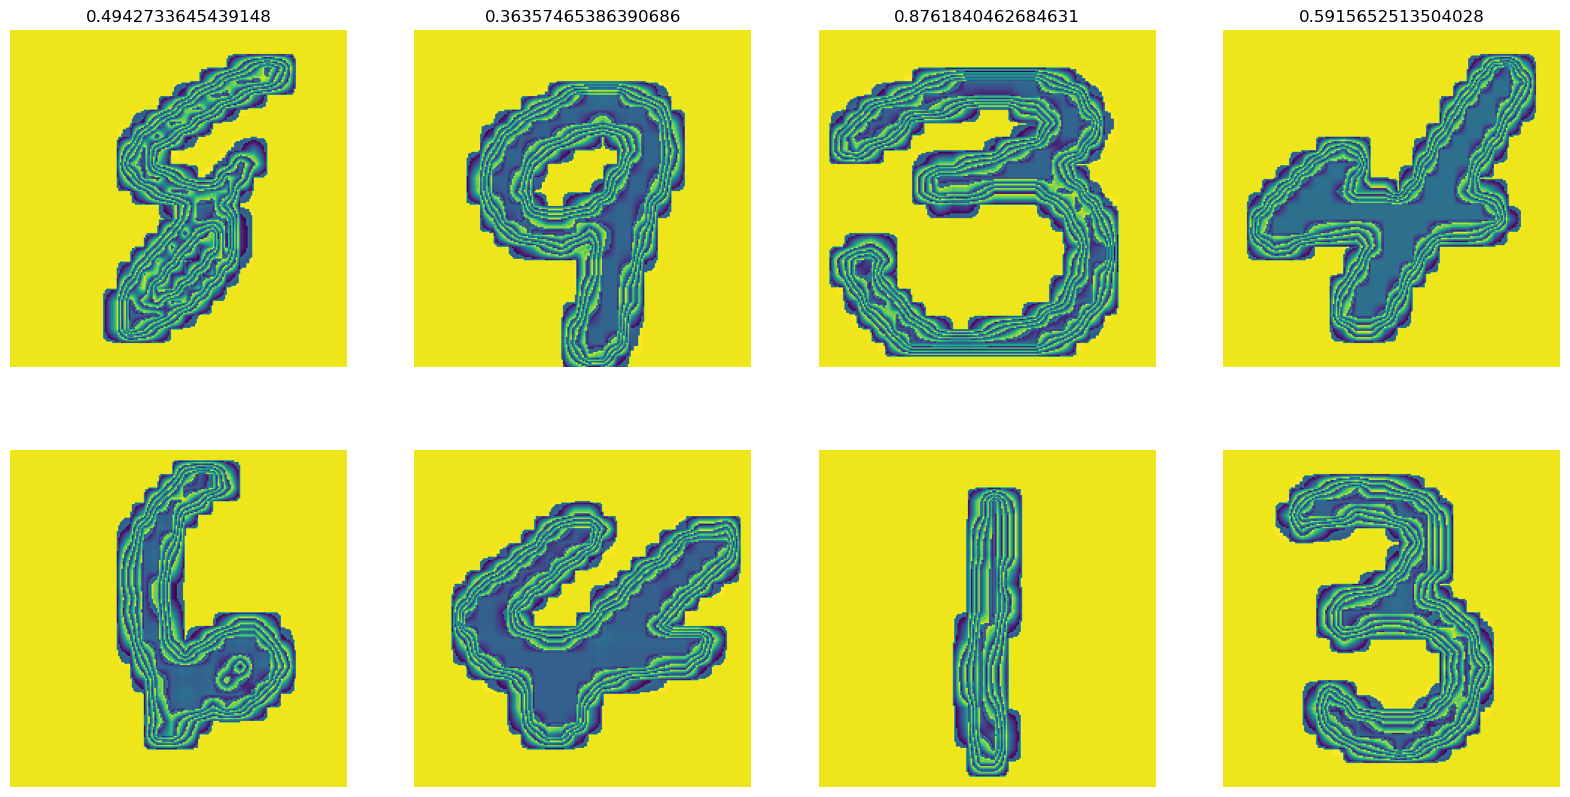

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i in range(4):
    t = np.random.randint(low=0, high=9)
    indexes = np.random.choice(range(500, 1000), size=1)

    img_vec1, img_vec2 = model.forward(test_dataset[indexes[0]][0].unsqueeze(0).to(device), test_dataset[indexes[0]][1].unsqueeze(0).to(device))

    distance = F.pairwise_distance(img_vec1, img_vec2)
    img1 = torchvision.transforms.functional.to_tensor(torchvision.transforms.functional.to_pil_image(test_dataset[indexes[0]][0]).convert('L'))
    img2 = torchvision.transforms.functional.to_tensor(torchvision.transforms.functional.to_pil_image(test_dataset[indexes[0]][1]).convert('L'))

    tensor1 = torch.from_numpy(np.array(img1))
    tensor2 = torch.from_numpy(np.array(img2))
    axs[0, i].imshow(tensor1.permute(1, 2, 0))
    axs[1, i].imshow(tensor2.permute(1, 2, 0))

    axs[0, i].axis('off')
    axs[0, i].set_title(float(distance.data[0]))
    axs[1, i].axis('off')